In [4]:
import sys
sys.path.append('../')
import config as cfg
import model as m
import dataset as d

import os
import pandas as pd


import re
import time
import random
import datetime

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

I0608 11:34:50.549492 139675367274240 file_utils.py:41] PyTorch version 1.4.0 available.


In [5]:
df = pd.read_csv(os.path.join(cfg.INPUT_BASE, 'train.csv'))

In [6]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [7]:
import re

In [8]:
def find_punct(text):
    line = re.findall(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', text)
    string="".join(line)
    return list(string)


def cleaning(text, selected_text, sentiment):
    """애매하게 잘린 답안의 경우 잘린 부분을 포함한 단어로 확장시켜준다."""
    if sentiment == 'neutral':
        return selected_text
    orig_selected_text = selected_text
    start = text.find(selected_text)
    end = start+len(selected_text)-1

    # 답안의 맨 뒤가 불완전하게 잘려 있으면 확장. 단, 구두점이라면 확장하지 않음
    if end+1 < len(text) and (text[end+1] != ' '):
        if len(find_punct(text[end+1])) > 0:
            pass
        elif len(find_punct(text[end])) > 0:
            pass
        else:
            # 우로 확장하기
            while end+1 < len(text) and text[end+1] != ' ' and len(find_punct(text[end+1])) == 0:
                selected_text += text[end+1]
                end += 1

    # 답안의 앞부분이 불완전하게 잘려있으면 확장. 단, 구두점이라면 확장하지 않음
    if start > 0 and text[start-1] != ' ':

        # 공통적으로, 답안 앞부분의 구두점은 무조건 제거
        removed = False
        while len(selected_text) > 0 and len(find_punct(selected_text[0])) > 0:
            selected_text = selected_text[1:]
            removed = True

        if removed:
            pass
        elif len(find_punct(text[start-1])) > 0:
            pass
        else:
            # 좌로 확장하기
            while start > 0 and text[start-1] != ' ' and len(find_punct(text[start-1])) == 0:
                selected_text = text[start-1] + selected_text
                start -= 1
    if len(selected_text) == 0:
        return orig_selected_text

    return selected_text

In [12]:
c = 0
for i, _id in enumerate(df.textID):
    row = df.iloc[i]
    train_dataset = d.TweetDataset(
        tweet=[row.text],
        sentiment=[row.sentmeint],
        selected_text=[row.selected_text],
        tokenizer=
    )
    clean_st = cleaning(row.text, row.selected_text, row.sentiment)
    if clean_st != row.selected_text:
        print("{} => {}".format(row.selected_text, clean_st))
        c += 1
c

onna => gonna
.no internet => no internet
well so much for being unhappy for about 10 minute => well so much for being unhappy for about 10 minutes
A little happy fo => A little happy for
dont like go => dont like going
d I`m not thrilled at all with mine. => and I`m not thrilled at all with mine.
, sorry guys =>  sorry guys
y adore => totally adore
e nice => be nice
.really bad => really bad
p sounds like fun => tweetup sounds like fun
e fun => have fun
d thank you! => and thank you!
I`m not sleeping at all un => I`m not sleeping at all until
g harmed => getting harmed
, he was soooo friendly. =>  he was soooo friendly.
.it`s gorgeous out! => it`s gorgeous out!
as wort => was worth
nan => nan
perfect ma => perfect match
Please Re => Please Review
.sorry => sorry
Have a good on => Have a good one
s I just don`t entertain him :/ => guess I just don`t entertain him :/
Wow what a beautiful pictur => Wow what a beautiful picture
! I`m scared of him =>  I`m scared of him
Sorr => Sorry
d the

1651

In [13]:
cfg.init_model_path()

In [14]:
m.init_tokenizer()

In [15]:
dataset = d.TweetDataset(
    tweet=df.text.values,
    sentiment=df.sentiment.values,
    selected_text=df.selected_text.values,
    tokenizer=m.tokenizer,
    max_seq_len=cfg.MAX_SEQ_LEN,
    model_type=cfg.MODEL_TYPE
)

In [18]:
dataset.t

array(['I`d have responded, if I were going', 'Sooo SAD', 'bullying me',
       ..., 'Yay good for both of you.', 'But it was worth it  ****.',
       'All this flirting going on - The ATG smiles. Yay.  ((hugs)'],
      dtype=object)

In [46]:
lens = []
starts = []
ends = []
for data in dataset:
    diff = data['targets_end']-data['targets_start']+1
    lens.append(diff.cpu().detach().numpy())
    starts.append(data['targets_start'].cpu().detach().numpy())
    ends.append(data['targets_end'].cpu().detach().numpy())

length of selected_text(token)

(array([1.7431e+04, 4.6980e+03, 3.0580e+03, 1.7670e+03, 4.9400e+02,
        2.9000e+01, 3.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 1. ,  9.5, 18. , 26.5, 35. , 43.5, 52. , 60.5, 69. , 77.5, 86. ]),
 <a list of 10 Patch objects>)

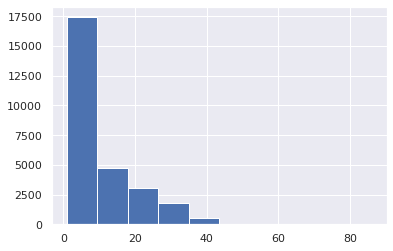

In [37]:
plt.hist(lens)

Start position

(array([1.9411e+04, 3.0750e+03, 2.1820e+03, 1.1760e+03, 8.7400e+02,
        5.1100e+02, 1.8500e+02, 5.3000e+01, 1.1000e+01, 3.0000e+00]),
 array([ 4. ,  8.7, 13.4, 18.1, 22.8, 27.5, 32.2, 36.9, 41.6, 46.3, 51. ]),
 <a list of 10 Patch objects>)

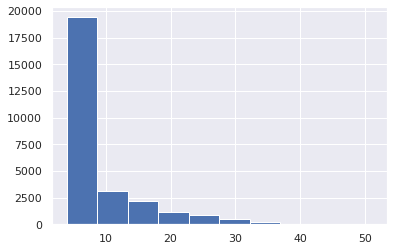

In [45]:
plt.hist(starts)

(array([1.1315e+04, 7.5340e+03, 5.2070e+03, 2.6830e+03, 7.0400e+02,
        3.3000e+01, 4.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 4. , 12.5, 21. , 29.5, 38. , 46.5, 55. , 63.5, 72. , 80.5, 89. ]),
 <a list of 10 Patch objects>)

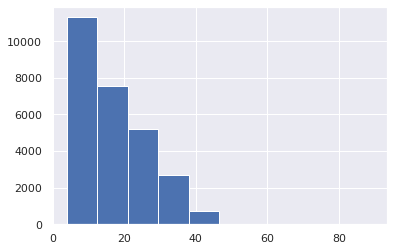

In [47]:
plt.hist(ends)

In [136]:
import torch
a = []
for i in range(1000):
    a.append(torch.rand(1, 100, 1000))

torch.stack(a).shape

torch.Size([1000, 1, 100, 1000])

## Test Result Analysis

In [60]:
df = pd.read_csv(os.path.join(cfg.INPUT_BASE, 'test.csv'))

In [61]:
df

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive
...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative
3530,416863ce47,All alone in this old house again. Thanks for...,positive
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive


In [81]:
df1 = pd.read_csv('./7125.csv')
df2 = pd.read_csv('./7128.csv')
df3 = pd.read_csv('./7133.csv')

In [82]:
df['7125'] = df1.selected_text.values
df['7128'] = df2.selected_text.values
df['7133'] = df3.selected_text.values

In [87]:
cnt = 0
lt = 0
gt = 0
for i, _ in enumerate(df.textID):
    row = df.iloc[i]
    if row['7125'] != row['7133']:
        print('sentim:', row.sentiment)
        print('  text:', row.text)
        print('winner:', row['7125']) # 0.719
        print(' loser:', row['7133']) # 0.712
        print()
        cnt += 1
        if len(row['7128']) < len(row['7133']):
            lt += 1
        else:
            gt += 1

cnt, lt, gt

sentim: negative
  text: Its coming out the socket  I feel like my phones hole is not a virgin. That`s how loose it is... :`(
winner:  I feel like my phones hole is not a virgin. That`s how loose it is...
 loser:  loose it is...

sentim: negative
  text: So hot today =_=  don`t like it and i hate my new timetable, having such a bad week
winner:  don`t like it and i hate my new timetable, having such a bad week
 loser:  hate my new timetable, having such a bad week

sentim: negative
  text: My dead grandpa pays more attention to me than you do
winner:  My dead grandpa pays more attention to me than you do
 loser:  My dead

sentim: negative
  text:   im really sorry i know wallah how u feel this life is shittttttttt
winner:  im really sorry
 loser:  sorry

sentim: negative
  text: : hmmm, wrong link, ignore my tweet
winner:  wrong
 loser:  wrong link, ignore

sentim: positive
  text: Happy Birthday Snickers!!!! ? I hope you have the best day ever! Let`s go shopping!!!
winner:  Happy Birt

(201, 85, 116)

In [162]:
from IPython.core.display import display, HTML

def visualize_text_segment(
        text, gt, pred=None,
        bg_color='rgb(255,255,0)', text_color='black', pred_bg_color='skyblue', pred_text_color='red'):
    
    start, end = gt
    end -= 1
    _start, _end = -1, -1
    if pred is not None:
        _start, _end = pred
        _end -= 1
    gt_tweet = "" 
    pred_tweet = ""
    
    for idx, char in enumerate(text):
        if idx == start:
            gt_tweet += "<span style='font-size:20px;background:{};color:{}'>".format(bg_color, text_color)
        if idx == _start:
            pred_tweet += "<span style='font-size:20px;background:{};color:{}'>".format(pred_bg_color, pred_text_color)
        
        if len(char.strip()) == 0:
            gt_tweet += "&nbsp;"
            pred_tweet += "&nbsp;"
        else:
            gt_tweet += char
            pred_tweet += char
        
        if idx == end:
            gt_tweet += '</span>' 
        if idx == _end:
            pred_tweet += '</span>'
           
    return HTML(gt_tweet), HTML(pred_tweet)

In [163]:
train_df = pd.read_csv(os.path.join(cfg.INPUT_BASE, 'train.csv'))
train_df['text'] = train_df.apply(lambda row: str(row.text).strip(), axis=1)
train_df['selected_text'] = train_df.apply(lambda row: str(row.selected_text).strip(), axis=1)

res_df = pd.read_csv('../7125res.csv')

In [175]:
diffs = []
for idx, _ in enumerate(res_df.textID):
    orig_row = train_df.iloc[idx]
    pred_row = res_df.iloc[idx]
    
    orig_tweet = ' '.join(orig_row.text.split())

    gt = ' '.join(orig_row.selected_text.split())
    pred = pred_row.selected_text.strip()
    

    if pred == gt:
        continue
    
    diffs.append(abs(len(gt.split())-len(pred.split())))
    
        
    #print(orig_row.sentiment)
    #print(orig_row.text)
    #print('truth:', gt)
    #print(' pred:', pred)
    
    idx_pred = [orig_tweet.find(pred) ,orig_tweet.find(pred)+len(pred)]
    idx_gt = [orig_tweet.find(gt), orig_tweet.find(gt)+len(gt)]
    
    # gt_tweet, pred_tweet = visualize_text_segment(orig_tweet ,idx_gt, idx_pred)
    
    # display(gt_tweet)
    # display(pred_tweet)
    #print()
    #print()


In [176]:
sum(diffs)/len(diffs)

3.9505784359093012

In [ ]:
for i, _ in enumerate(res_df.textID):
    row = res_df.iloc[i]
    orig_row = train_df.iloc[i]
    
    if row['selected_text'].strip() != orig_row['selected_text'].strip():
        print(orig_row.text)
        print('orig:', orig_row.selected_text.strip())
        print('pred:', row.selected_text.strip())
        print()
